In this demo, I'm going to show you how to build a vanilla **Generative Adverserial Network** ([GAN](https://en.wikipedia.org/wiki/Generative_adversarial_network)) to generate **MNIST** handwritten digits using `autodiff`.


A little background on GANs:

<p align="center"><img src="GANs.png" width="600"> </p>

image credit: [https://skymind.ai/wiki/generative-adversarial-network-gan](https://www.google.com/url?sa=i&source=images&cd=&cad=rja&uact=8&ved=2ahUKEwjczYv39prjAhWRM94KHbMuBHYQjhx6BAgBEAM&url=https%3A%2F%2Fskymind.ai%2Fwiki%2Fgenerative-adversarial-network-gan&psig=AOvVaw3lqvE8XzKsLOi-PxnaxWqv&ust=1562318182236540)

Conceptually, the game of GAN involves two players: the **police** (i.e. Discriminator) tries to detect fake banknotes from real ones, while the **counterfeiter** (i.e. Generator) tries to produce fake money that can fool the police (make them believe the fake money are indeed real money).

More technically, training a GAN involves the following steps:

1. First we sample a batch of vectors $z$ from a $d$-dimensional distribution $p_{z}(z)$. For example, each $z$ could be a 100-dimensional vector, where its components are identically (e.g. Standard Normal or random uniform distribution) and independently distributed (I.I.D.)

$$z \sim p_{z}(z), z \in \mathbb{R}^{100}$$

2. Then we feed the batch of $z$'s into the **Generator** $G(z; \theta_{g})$, which is a neural network (e.g. with convolutional layers, fully connected layers etc.) that turns each $z$ into a 784-dimensional vector that can be reshaped into a 28 by 28 gray scale image.

$$x_{fake} = G(z), x_{fake} \in \mathbb{R}^{784}$$

Note: the generated images $x_{fake}$ follows a distribution that we refer to as $p_{g}(x)$.

3. Next, we are going to sample a batch of real images $x_{real}$, from our training set -- a 784-dimensional distribution $p_{data}(x)$

Note: both $x_{real}$ and $x_{fake}$ are 784-dimensional vectors, except that they come from different distributions, i.e. $p_{data}(x)$ and $p_{g}(x)$
4. Finally, we will combine $x_{real}$'s and $x_{fake}$'s and feed them into the **Discriminator** $D(x; \theta_{d})$, which is also a neural network that performs binary classification on each $x_{real}$ and $x_{fake}$. We **train the Discriminator** by updating its parameters $\theta_{d}$, in the hope that $x_{real}$ outputs 1's, and $x_{fake}$ outputs 0's. In the *meantime*, we **train the Generator** by updateing its parameters $\theta_{g}$, in the hope that $x_{fake}$ outputs 1's.

In this adverserial training, we let the Generator and Discriminator "screw up" each other's job. In the end, we would like to make the distribution $p_{g}(x)$ to be identical to $p_{data}(x)$ *everywhere*.

In [1]:
import gzip
import numpy as np

import autodiff as ad
from autodiff import initializers
from autodiff import optimizers

For training the GAN, we will only use the MNIST handwritten digits (no labels are needed).

In [2]:
def read_mnist_images(fn):
  with gzip.open(fn, 'rb') as f:
    content = f.read()
    num_images = int.from_bytes(content[4:8], byteorder='big')
    height = int.from_bytes(content[8:12], byteorder='big')
    width = int.from_bytes(content[12:16], byteorder='big')
    images = np.fromstring(content[16:], dtype=np.uint8).reshape((num_images, height, width))
  images = images.astype(np.float32) / 255.
  return images

train_images = read_mnist_images('train-images-idx3-ubyte.gz')

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

# training set contains 60000 images
print(train_images.shape)

(60000, 28, 28, 1)


The GAN is composed of a Generator network and a Discriminator network, each of which contains trainable weights. The trainable weights may need different initializers:

* Random uniform initializer for convolutional and fully connected layers.
* Zeros initializer for biases, offsets of Batch Normalization. 
* Ones initializer for scales of Batch Normalization.

We set 100 as the dimensionality of the noise vector $z$, and 250 as the batch size.

In [3]:
rui = initializers.RandomUniformInitializer(minval=-0.0001, maxval=0.0001)
zi = initializers.ZerosInitializer()
oi = initializers.OnesInitializer()

noise_dim = 100
BATCH_SIZE = 250

The Generator converts a `[BatchSize, 100]` tensor into a `[BatchSize, 28, 28, 1]` tensor.

The layers are listed below:

|layer|stride|kernel| output dimension|output tensor shape|
|--|--|--|--|--|
|Fully connected|n/a|n/a|12544|[BatchSize, 12544]|
|Reshape|n/a|n/a|n/a|[BatchSize, 7, 7, 256]
|Transposed Conv2D|1|5|128|[BatchSize, 7, 7, 128]|
|BatchNorm|n/a|n/a|n/a|[BatchSize, 7, 7, 128]|
|LeakReLU|n/a|n/a|n/a|[BatchSize, 7, 7, 128]|
|Transposed Conv2D|2|5|64|[BatchSize, 14, 14, 64]|
|BatchNorm|n/a|n/a|n/a|[BatchSize, 14, 14, 64]|
|LeakReLU|n/a|n/a|n/a|[BatchSize, 14, 14, 64]|
|Transposed Conv2D|2|5|1|[BatchSize, 28, 28, 1]|
|Tanh|n/a|n/a|n/a|[BatchSize, 28, 28, 1]|

In [4]:
def build_generator(noise, is_training=True, epsilon=0.001, decay=0.999):

  dense0_weight = ad.variable((noise_dim, 12544), rui)
  dense0_offset = ad.variable((12544,), zi)
  dense0_scale = ad.variable((12544,), oi)
  dense0_moving_mean = ad.variable((12544,), zi)
  dense0_moving_variance = ad.variable((12544,), oi)

  tconv0_weight = ad.variable((5, 5, 128, 256), rui)
  tconv0_offset = ad.variable((128,), zi)
  tconv0_scale = ad.variable((128,), oi)
  tconv0_moving_mean = ad.variable((128,), zi)
  tconv0_moving_variance = ad.variable((128,), oi)

  tconv1_weight = ad.variable((5, 5, 64, 128), rui)
  tconv1_offset = ad.variable((64,), zi)
  tconv1_scale = ad.variable((64,), oi)
  tconv1_moving_mean = ad.variable((64,), zi)
  tconv1_moving_variance = ad.variable((64,), oi)

  tconv2_weight = ad.variable((5, 5, 1, 64), rui)

  var_list = [dense0_weight, dense0_offset, dense0_scale, tconv0_weight, tconv0_offset, tconv0_scale,
      tconv1_weight, tconv1_offset, tconv1_scale, tconv2_weight]

  dense0 = ad.leaky_relu(
      ad.fused_batch_norm(ad.matmul(noise, dense0_weight),
          dense0_scale,
          dense0_offset,
          dense0_moving_mean,
          dense0_moving_variance,
          is_training=is_training, epsilon=epsilon, decay=decay), alpha=0.3)


  reshaped = ad.reshape(dense0, [-1, 7, 7, 256])

  tconv0 = ad.leaky_relu(
      ad.fused_batch_norm(ad.conv2d_transpose(reshaped, tconv0_weight, [1, 1], 'SAME'),
          tconv0_scale,
          tconv0_offset,
          tconv0_moving_mean,
          tconv0_moving_variance,
          is_training=is_training, epsilon=epsilon, decay=decay), alpha=0.3)

  tconv1 = ad.leaky_relu(
      ad.fused_batch_norm(ad.conv2d_transpose(tconv0, tconv1_weight, [2, 2], 'SAME'),
          tconv1_scale,
          tconv1_offset,
          tconv1_moving_mean,
          tconv1_moving_variance,
          is_training=is_training, epsilon=epsilon, decay=decay), alpha=0.3)

  tconv2 = ad.tanh(ad.conv2d_transpose(tconv1, tconv2_weight, [2, 2], 'SAME'))

  return tconv2, var_list


The Discriminator converts a `[BatchSize, 28, 28, 1]` tensor into a `[BatchSize, 1]` tensor (i.e. the predicted logits).

The layers are listed below:

|layer|stride|kernel| output dimension|output tensor shape|
|--|--|--|--|--|
|Conv2D|2|5|64|[BatchSize, 14, 14, 64]|
|LeakyReLU|n/a|n/a|n/a|[BatchSize, 14, 14, 64]|
|Dropout|n/a|n/a|n/a|[BatchSize, 14, 14, 64]|
|Conv2D|2|5|128|[BatchSize, 7, 7, 128]|
|LeakyReLU|n/a|n/a|n/a|[BatchSize, 7, 7, 128]|
|Dropout|n/a|n/a|n/a|[BatchSize, 7, 7, 128]|
|Reshape|n/a|n/a|n/a|[BatchSize, 6272]|
|Fully connected|n/a|n/a|1|[BatchSize, 1]|

In [5]:
def build_discriminator(images, is_training=True):
  conv0_weight = ad.variable((5, 5, 1, 64), rui)
  conv0_biases = ad.variable((64,), zi)

  conv1_weight = ad.variable((5, 5, 64, 128), rui)
  conv1_biases = ad.variable((128,), zi)

  dense0_weight = ad.variable((6272, 1), rui)
  dense0_biases = ad.variable((1,), zi)

  var_list = [conv0_weight, conv0_biases, conv1_weight, conv1_biases, dense0_weight, dense0_biases]

  conv0 = ad.leaky_relu(ad.conv2d(images, conv0_weight, [2, 2], 'SAME') + conv0_biases, alpha=0.3)
  conv0 = ad.dropout(conv0, 0.3, is_training=is_training)

  conv1 = ad.leaky_relu(ad.conv2d(conv0, conv1_weight, [2, 2], 'SAME') + conv1_biases, alpha=0.3)
  conv1 = ad.dropout(conv1, 0.3, is_training=is_training)

  reshaped = ad.reshape(conv1, (-1, 7 * 7 * 128))

  logits = ad.add(ad.matmul(reshaped, dense0_weight), dense0_biases)

  return logits, var_list

Finally, we create the computeational `graph`, and place nodes inside the graph.

In [6]:
graph = ad.Graph()
with graph.as_default_graph():
  noise = ad.placeholder((None, noise_dim))
  fake_images, g_var_list = build_generator(noise, True)

  real_images = ad.placeholder((None, 28, 28, 1))

  images = ad.concat([real_images, fake_images], axis=0)

  logits, d_var_list = build_discriminator(images, True)

  labels = ad.constant(np.concatenate([np.ones((BATCH_SIZE, 1), dtype='float32'),
      np.zeros((BATCH_SIZE, 1), dtype='float32')], axis=0))

  fake_labels = ad.constant(np.ones((BATCH_SIZE, 1), dtype='float32'))
  fake_logits = ad.slice(logits, (BATCH_SIZE, 0), (-1, -1))

  discriminator_loss = ad.reduce_mean(ad.sigmoid_cross_entropy_loss(labels, logits))
  generator_loss = ad.reduce_mean(ad.sigmoid_cross_entropy_loss(fake_labels, fake_logits))

  # the `logits` is branched out into two paths (i.e. discriminator loss and generator loss),
  # and the gradient is backpropped separately from the two paths, so we have to set the
  # number of consumers (i.e. num of child nodes) to 1.
  logits.set_num_consumers(1)


Initialize the variables, and create a `RunTime` for the `graph`:

In [7]:
graph.initialize_variables()
runtime = ad.RunTime()
graph.set_runtime(runtime)


We use Adam optimizer to train both Discriminator and Generator.

In [8]:
optimizer = optimizers.AdamOptimizer(alpha=1e-4, beta1=.9, beta2=.999, epsilon=1e-8)

We train the GAN for 12000 iteraions. In each iteration, we sample `BATCH_SIZE` real images from the training set, and also `BATCH_SIZE` 100-dimensional vectors from the Standard Normal distribution.

The gradients w.r.t Discriminator variables and Generator variables are computed separately.

For every 240 iterations, we print out the average loss for Discriminator and Generator, and save the variables to `dcgan_*.npy`.

In [9]:
d_losses, g_losses = [], []
for i in range(12000):
  if i % 100 == 0:
    print(i)
  which = np.random.choice(train_images.shape[0], BATCH_SIZE, False)

  inputs_val = train_images[which]

  feed_dict = {noise: np.random.normal(size=(BATCH_SIZE, noise_dim)).astype('float32'),
              real_images: inputs_val}

  # We add tensor `images` to `grad_stopped_nodes`, so when training Discriminator,
  # the gradient won't be backpropped to the Generator, which is unnecessary.  
  with runtime.forward_backward_cycle(grad_stopped_nodes=[images]):

    d_grads_and_vars = optimizer.compute_gradients(discriminator_loss, feed_dict, d_var_list)
    d_loss_val = discriminator_loss.forward(feed_dict)

  with runtime.forward_backward_cycle():
    g_grads_and_vars = optimizer.compute_gradients(generator_loss, feed_dict, g_var_list)
    g_loss_val = generator_loss.forward(feed_dict)

  optimizer.apply_gradients(d_grads_and_vars + g_grads_and_vars)

  d_losses.append(d_loss_val)
  g_losses.append(g_loss_val)

  # print average loss for Discriminator and Generator every 240 minibatches 
  if i % 240 == 0:
    print(i / 240, np.mean(d_losses), np.mean(g_losses))
    d_losses, g_losses = [], []
    graph.save_variables('dcgan_%d' % i)
    
graph.save_variables('dcgan_%d' % 12000)    

0   0.693147  0.693147
1   0.664795  0.633643
2   0.636123  0.778458
3   0.622394  0.895870
4   0.608690  0.939475
5   0.631007  0.901853
6   0.712173  0.749567
7   0.674467  0.772681
8   0.643163  0.792259
9   0.659910  0.807012
10  0.637281  0.866058
11  0.649869  0.841240
12  0.661141  0.838735
13  0.647865  0.815088
14  0.666641  0.793087
15  0.634156  0.867826
16  0.653299  0.842085
17  0.639283  0.848952
18  0.617050  0.927171
19  0.622325  0.919500
20  0.634446  0.892639
21  0.607611  0.942640
22  0.619991  0.944714
23  0.574591  1.045856
24  0.557011  1.025414
25  0.580778  1.060245
26  0.547464  1.095213
27  0.553785  1.092038
28  0.528367  1.216884
29  0.500977  1.288211
30  0.542414  1.131237
31  0.536479  1.146759
32  0.547053  1.139934
33  0.544872  1.189545
34  0.500951  1.254399
35  0.532172  1.230772
36  0.542510  1.168917
37  0.543197  1.174883
38  0.570626  1.137430
39  0.575446  1.098001
40  0.553998  1.123108
41  0.590563  1.095345
42  0.594575  1.066379
43  0.60077

**WARNING**: the above code snippet takes ~13 hours, because `autodiff` is completely based on NumPy that only runs on CPU. 

If you don't want to train for that long, here is the link for a file ([dcgan_12000.npy](https://www.dropbox.com/sh/zngqlkq989m3yu6/AAD4OSCwT9JkZWT0yY7FxIkDa?dl=0)) holding the weights of trained variables.

Once training is finished, let's check out the generated images.

In [10]:
import imageio
import glob
import os
import matplotlib.pyplot as plt
from IPython import display

We create a separate graph for generator, and set the `is_training` flag to `False`.

In [11]:
test_graph = ad.Graph()
with test_graph.as_default_graph():
  noise = ad.placeholder((None, noise_dim))
  fake_images, g_var_list = build_generator(noise, is_training=False)

runtime = ad.RunTime()
test_graph.set_runtime(runtime)  

Create a function to save and plot generated images

In [12]:
def plot_images(images_val, epoch):
  fig = plt.figure(figsize=(4, 4))
  for i in range(images_val.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images_val[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

  if not os.path.exists('images'):
    os.mkdir('images')

  plt.savefig('images/{:05d}.png'.format(epoch))
  plt.show()

We sample 16 100-dimensional vectors as noises, and plot the generated images as training progresses.

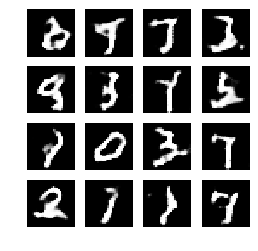

In [13]:
var_list = test_graph.get_variables(False)
random_state = np.random.RandomState(1)
feed_dict = {noise: random_state.normal(size=(16, noise_dim)).astype('float32')}

for i in range(0, 12000, 240):
  d = np.load('dcgan_%d.npy' % i).item()
  for v in var_list:
    v.set_val(d[v.name])
  with runtime.forward_backward_cycle():
    images_val = fake_images.forward(feed_dict) 
  print(i)
  display.clear_output(wait=True)
  plot_images(images_val, i)

Finally, let's put together the generated images as a GIF file.

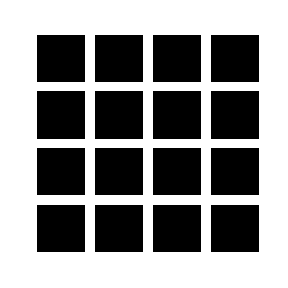

In [14]:
with imageio.get_writer('dcgan.gif', mode='I') as writer:
  filenames = glob.glob('images/*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
    
os.system('cp dcgan.gif dcgan.gif.png')
display.Image(filename="dcgan.gif.png")